# Test validity step 2 : $P(s_c | ...) \propto (s_c - s_{c,WF})^t (C^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) (s_c - s_{c,WF})$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.experimental.sparse as jsparse
import chex as chx
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro.distributions as dist
import toml
import lineax as lx
import fgbuster
from fgbuster import get_instrument, get_observation, get_noise_realization
from lanczos_test import *

import micmac as micmac

In [2]:
PRNGKey = random.PRNGKey(0)


In [3]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')

In [4]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/Paper_runs_v3/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'main_params/'
directory_additional_params = working_directory_path + 'additional_params/'

path_toml_file = directory_toml_file + 'corr_cutsky_SO_r0_v1c.toml'
path_additional_params = directory_additional_params + 'add_corr_cutsky_SO_d0s0_nside0_v1a.toml'

In [5]:
foreground_bool = True

In [6]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

No spatial variability case



>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]
    f0
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None

>>> Tree of spv config after filling the missing values:
root
  nside_spv
    default: [0]
    f0
      default: [0]
      b0
        default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]
    f1
      default: [0]
      b0
        default: [0]
      b1
        default: [0]
      b2
        default: [0]
      b3
        default: [0]


In [7]:
with open(path_additional_params) as f:
    dictionary_additional_parameters = toml.load(f)
f.close()

In [8]:
instrument = fgbuster.get_instrument(MICMAC_sampler_obj.instrument_name)

fgs_model_ = dictionary_additional_parameters['fgs_model']

np.random.seed(dictionary_additional_parameters['seed_realization_input'])
noise_map = get_noise_realization(MICMAC_sampler_obj.nside, instrument)[:, 1:, :]

if foreground_bool:
    fgs_model = dictionary_additional_parameters['fgs_model']
    np.random.seed(dictionary_additional_parameters['seed_realization_input'])
    freq_maps_fgs_denoised = get_observation(instrument, fgs_model_, nside=MICMAC_sampler_obj.nside, noise=False)[:, 1:, :]   # keep only Q and U
    

    freq_maps_fgs = freq_maps_fgs_denoised + noise_map
else:
    freq_maps_fgs = noise_map
instrument

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


frequency  depth_p  depth_i  fwhm  f_sky    status  \
0       27.0     49.5     35.0  91.0    0.1  forecast   
1       39.0     29.7     21.0  63.0    0.1  forecast   
2       93.0      3.7      2.6  30.0    0.1  forecast   
3      145.0      4.7      3.3  17.0    0.1  forecast   
4      225.0      8.9      6.3  11.0    0.1  forecast   
5      280.0     22.6     16.0   9.0    0.1  forecast   

                                           reference    type  \
0  Journal of Cosmology and Astroparticle Physics...  ground   
1  Journal of Cosmology and Astroparticle Physics...  ground   
2  Journal of Cosmology and Astroparticle Physics...  ground   
3  Journal of Cosmology and Astroparticle Physics...  ground   
4  Journal of Cosmology and Astroparticle Physics...  ground   
5  Journal of Cosmology and Astroparticle Physics...  ground   

                                  note experiment  
0  depth_p is simply depth_i * sqrt(2)     SO_SAT  
1  depth_p is simply depth_i * sqrt(2)     SO_SAT  
2  depth_p is simply depth_i * sqrt(2)     SO_SAT  
3  depth_p is simply depth_i * sqrt(2)     SO_SAT  
4  depth_p is simply depth_i * sqrt(2)     SO_SAT  
5  depth_p is simply depth_i * sqrt(2)     SO_SAT

F_sky =  0.6038818359375


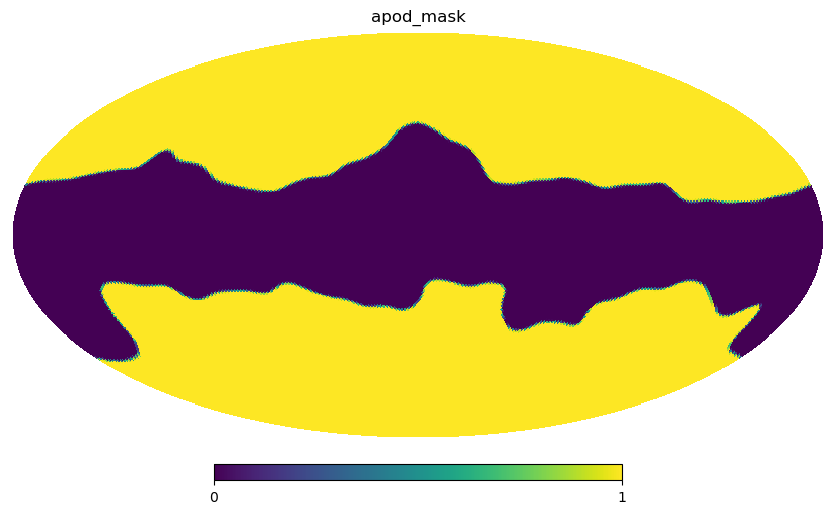

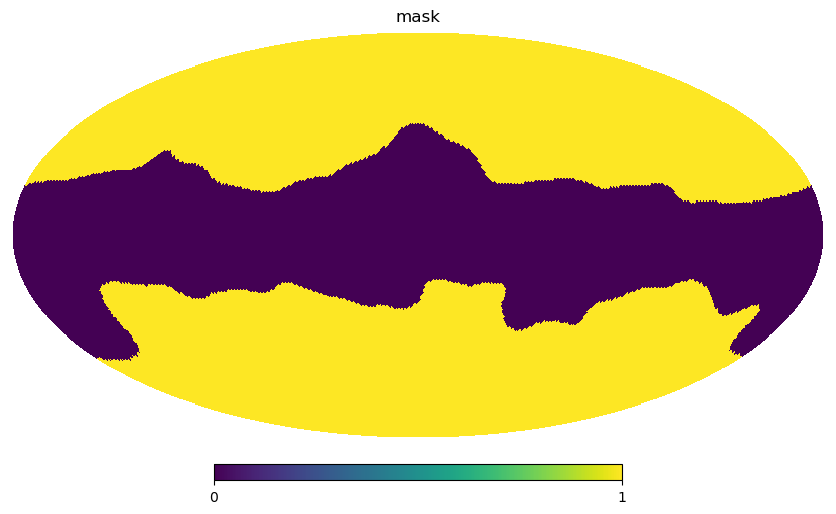

In [9]:
# path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"
path_mask = "/Users/mag/Documents/PHD1Y/Masks/Planck_mask_fsky_60.fits"

relative_treshold = 3*1e-1

apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside, dtype=np.float64)
mask = np.copy(apod_mask)

# mask[apod_mask>0] = 1
mask[apod_mask<=relative_treshold] = 0
mask[apod_mask>relative_treshold] = 1

mask = mask.astype(np.int64)

print("F_sky = ", np.sum(mask)/len(mask))

hp.mollview(apod_mask, title='apod_mask')
hp.mollview(mask, title='mask')


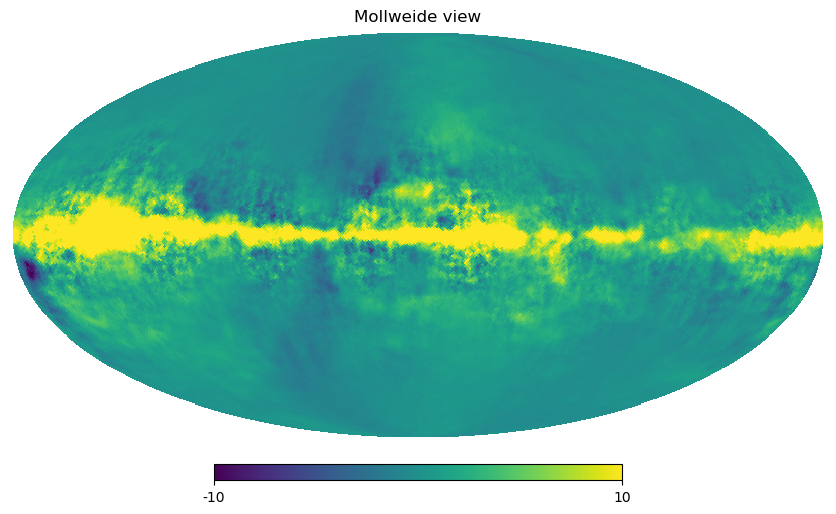

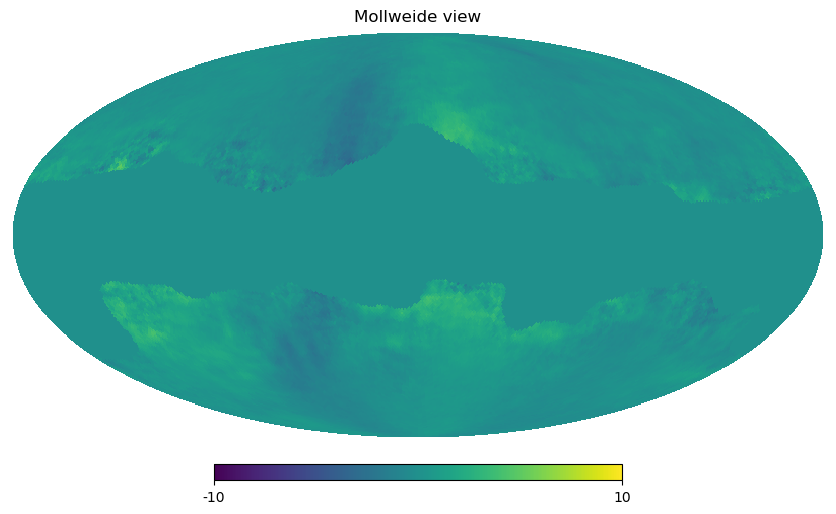

In [10]:
hp.mollview(freq_maps_fgs[2,0], min=-10, max=10) # Freq, nstokes, n_pix
hp.mollview(freq_maps_fgs[2,0]*mask, min=-10, max=10) # Freq, nstokes, n_pix

In [11]:
# mask = np.ones(MICMAC_sampler_obj.n_pix)

MICMAC_sampler_obj.mask = np.array(mask)

In [12]:
# freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)
freq_inverse_noise_0 = micmac.get_noise_covar(instrument['depth_p'], MICMAC_sampler_obj.nside) #MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = micmac.get_noise_covar_extended(instrument['depth_p'], MICMAC_sampler_obj.nside)*MICMAC_sampler_obj.mask

MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked

freq_inverse_noise = freq_inverse_noise_masked

MICMAC_sampler_obj.freq_noise_c_ell = micmac.get_true_Cl_noise(np.array(instrument['depth_p']), MICMAC_sampler_obj.lmax)

In [13]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [14]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(freqs=np.array(instrument['frequency']), 
                                                 ncomp=MICMAC_sampler_obj.n_components, 
                                                 pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, 
                                                 spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b)
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], 
                                        n_components=MICMAC_sampler_obj.n_components, 
                                        params=init_params, 
                                        pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs, 
                                        spv_nodes_b=MICMAC_sampler_obj.spv_nodes_b, 
                                        nside=MICMAC_sampler_obj.nside)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

invBtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(freq_inverse_noise), mixing_matrix_sampled)#*mask

BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)


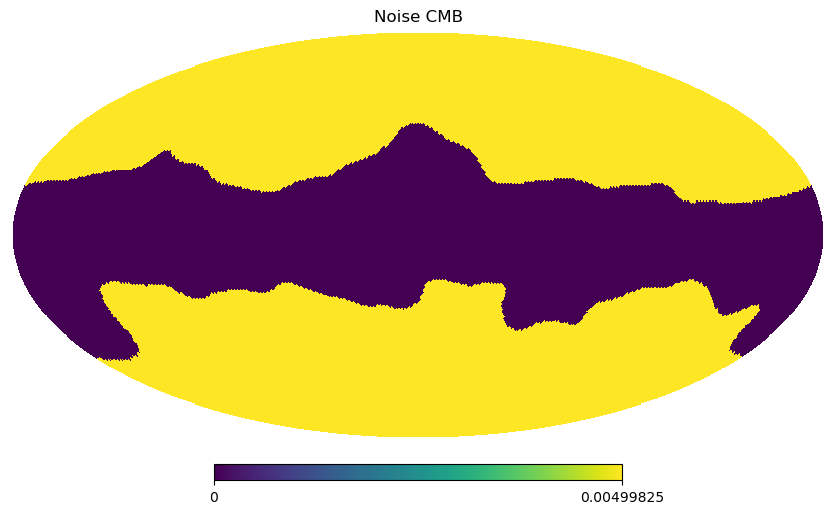

In [15]:
hp.mollview(invBtinvNB[0,0], title='Noise CMB')

In [16]:
np.random.seed(dictionary_additional_parameters['seed_realization_input']+1)

input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask
# input_cmb_maps = input_cmb_maps*mask

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [17]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps_masked, jax_use=True)[0, :, :]

In [18]:
n_frequencies = MICMAC_sampler_obj.n_frequencies
n_components = MICMAC_sampler_obj.n_components
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter
n_pix = 12*nside**2

In [19]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor
# red_cov_matrix_sample = theoretical_red_cov_r0_total + 1e-3 * theoretical_red_cov_r1_tensor

In [20]:
first_part_term_left = lambda x : micmac.maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), 
                                                                        red_cov_matrix_sqrt, 
                                                                        nside=MICMAC_sampler_obj.nside, 
                                                                        lmin=MICMAC_sampler_obj.lmin, 
                                                                        n_iter=MICMAC_sampler_obj.n_iter).ravel()
N_c_inv = jnp.copy(invBtinvNB[0,0])
N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
N_c_inv_repeat = jnp.broadcast_to(N_c_inv, (MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)).ravel() 
N_c_repeat = jnp.broadcast_to(invBtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2, (MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)).ravel()

def second_part_term_left(x):
    return x*N_c_inv_repeat

func_to_apply = lambda x : x.ravel() + first_part_term_left(second_part_term_left(first_part_term_left(x)))

In [21]:
red_cov_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_matrix_sample)

In [76]:
noise_c_ell = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0]

red_inv_noise_c_ell = jnp.linalg.pinv(micmac.get_reduced_matrix_from_c_ell_jax(jnp.stack([noise_c_ell, noise_c_ell, jnp.zeros_like(noise_c_ell)])))[lmin:]

# red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))
# red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell*f_sky, red_cov_matrix_sqrt))
red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))*f_sky
red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))/f_sky
# red_solution = jnp.eye(nstokes) - jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell*f_sky**2, red_cov_matrix_sqrt)

precond_test = lambda x: micmac.maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_solution, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

mask_repeat = jnp.broadcast_to(mask, (MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)).ravel()

precond_test_b = lambda x: micmac.maps_x_red_covariance_cell_JAX((x*mask_repeat).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_solution, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()
precond_test_b = lambda x: (micmac.maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_solution, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)*MICMAC_sampler_obj.mask).ravel()


red_cov_matrix_inv = jnp.linalg.pinv(red_cov_matrix_sample)
red_cov_matrix_inv = jnp.linalg.pinv(red_cov_matrix_sqrt)
N_c_repeat_sqrt = np.sqrt(N_c_repeat)

N_c_v2 = jnp.copy(invBtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
N_c_v2 = N_c_v2.at[...,MICMAC_sampler_obj.mask==0].set(10000*N_c_v2[MICMAC_sampler_obj.mask!=0].mean())
N_c_repeat_v2 = jnp.broadcast_to(N_c_v2, (MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)).ravel()


# precond_test_2 = lambda x: micmac.maps_x_red_covariance_cell_JAX((x*N_c_repeat).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_cov_matrix_inv, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()
precond_test_2 = lambda x: micmac.maps_x_red_covariance_cell_JAX((x*N_c_repeat_sqrt).reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_cov_matrix_inv, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

precond_test_2b = lambda x: precond_test_2(x)*N_c_repeat
# precond_test_2b = lambda x: precond_test_2(x)*N_c_repeat_v2


# red_solution_b = jnp.eye(nstokes) - jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt)
# red_solution_b = jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt)
red_solution_b = jnp.linalg.pinv(jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))

precond_test_3 = lambda x: micmac.maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_solution_b, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()

precond_test_4 = lambda x: precond_test_3(x) + precond_test_2b(x)


In [23]:
test_noise_covar = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)

num_samples = 20

N_c_inv_ = jnp.zeros_like(invBtinvNB[0,0])
# N_c_inv_ = N_c_inv_.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
N_c_inv_ = N_c_inv_.at[...].set(1/invBtinvNB[0,0,0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)

PRNGKey = jax.random.PRNGKey(0)
c_ells = np.zeros((num_samples, MICMAC_sampler_obj.n_correlations, MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin))
for i in range(num_samples):
    PRNGKey, subkey = jax.random.split(PRNGKey)
    # random_map = jax.random.normal(subkey, shape=(MICMAC_sampler_obj.n_pix,))*N_c_inv_/jhp.nside2resol(MICMAC_sampler_obj.nside)
    # random_map = jax.random.normal(subkey, shape=(MICMAC_sampler_obj.n_pix,))*invBtinvNB[0,0]#/jhp.nside2resol(MICMAC_sampler_obj.nside)

    # random_map = jax.random.normal(subkey, shape=(MICMAC_sampler_obj.n_pix,))*np.sqrt(invBtinvNB[0,0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2)/jhp.nside2resol(MICMAC_sampler_obj.nside)
    random_map = jax.random.normal(subkey, shape=(MICMAC_sampler_obj.n_pix,))*np.sqrt(invBtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2)/jhp.nside2resol(MICMAC_sampler_obj.nside)

    random_map_extended = np.vstack([np.zeros_like(random_map), random_map, random_map])
    c_ells[i,:] = hp.anafast(random_map_extended, iter=MICMAC_sampler_obj.n_iter, lmax=MICMAC_sampler_obj.lmax)[indices_polar,MICMAC_sampler_obj.lmin:]

noise_cell_2 = micmac.get_inv_BtinvNB_c_ell(MICMAC_sampler_obj.freq_noise_c_ell, mixing_matrix_sampled.mean(axis=2))[0,0]

In [72]:
test = func_to_apply(right_member_Fluct)
test_2 = precond_test(func_to_apply(right_member_Fluct))

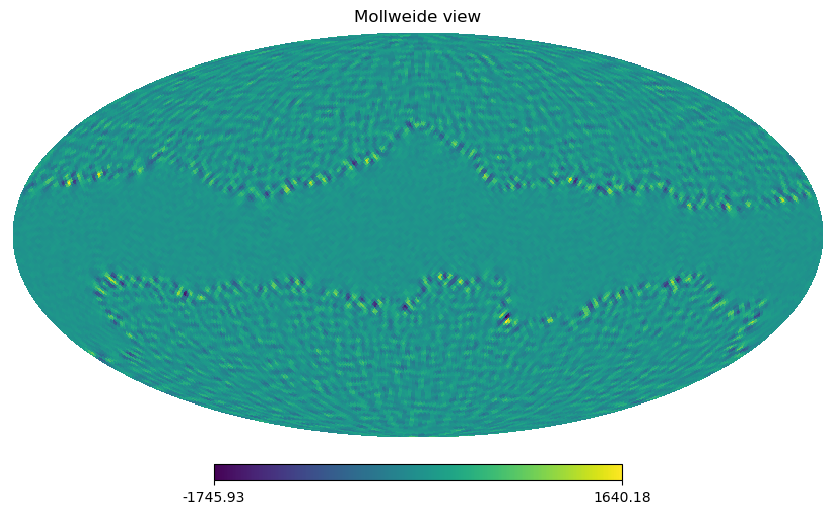

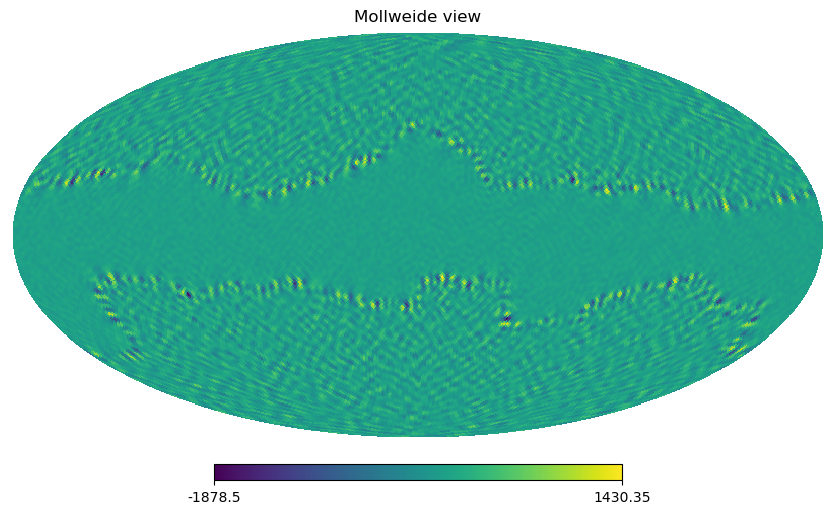

In [73]:
hp.mollview((right_member_Fluct-test_2)[:MICMAC_sampler_obj.n_pix])
hp.mollview((right_member_Fluct-test_2)[MICMAC_sampler_obj.n_pix:])

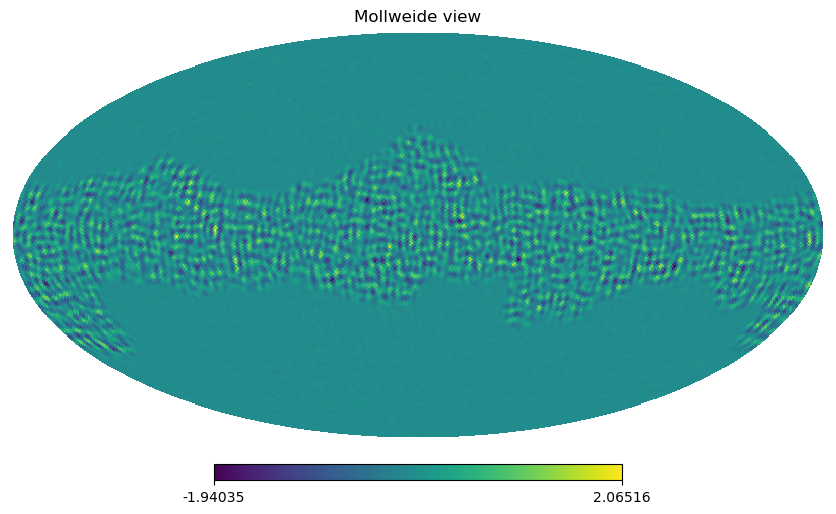

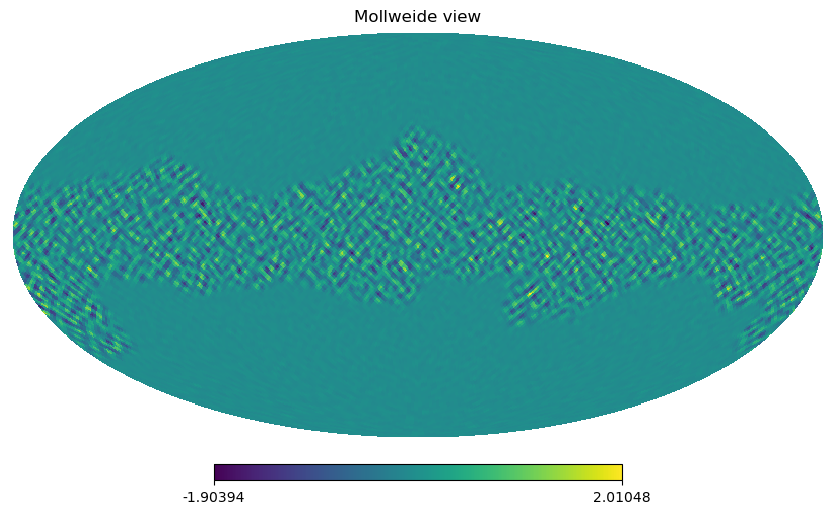

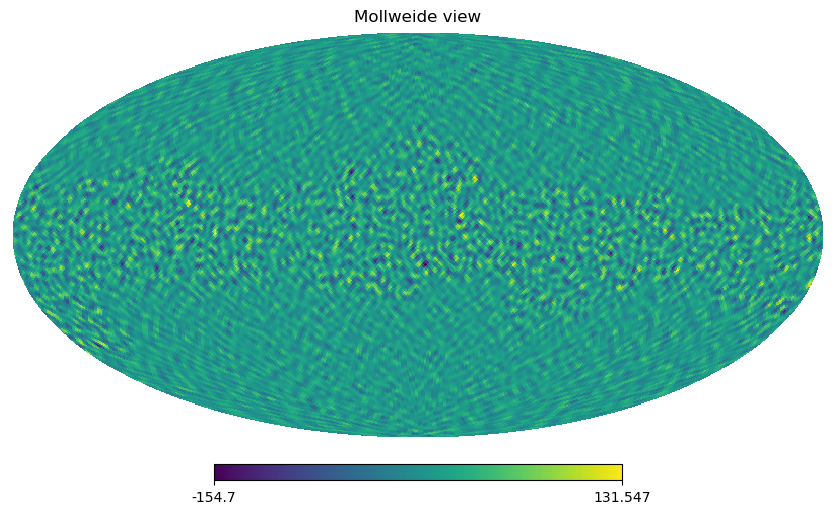

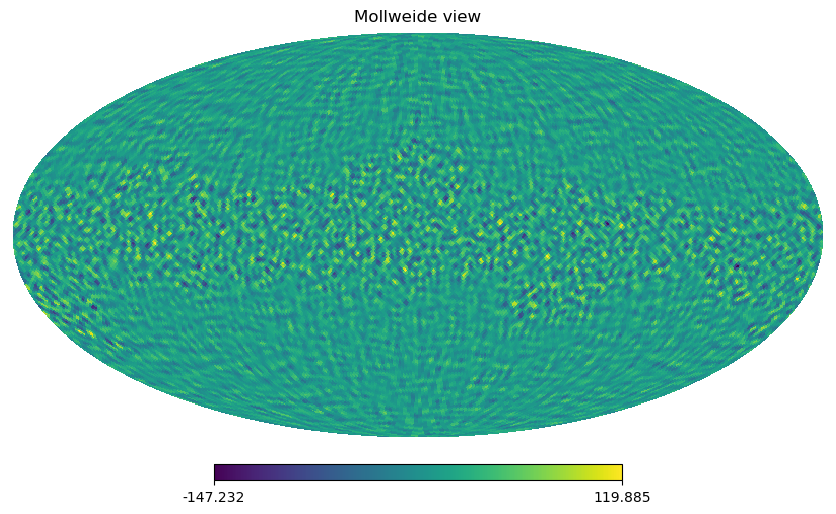

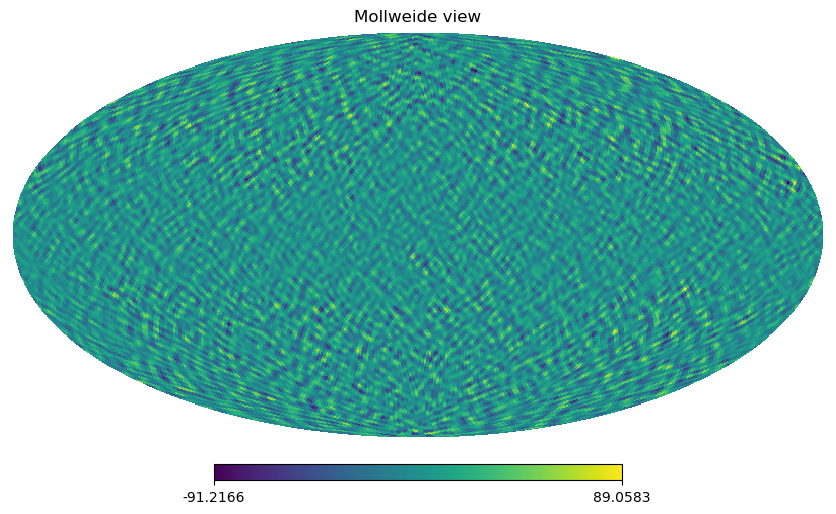

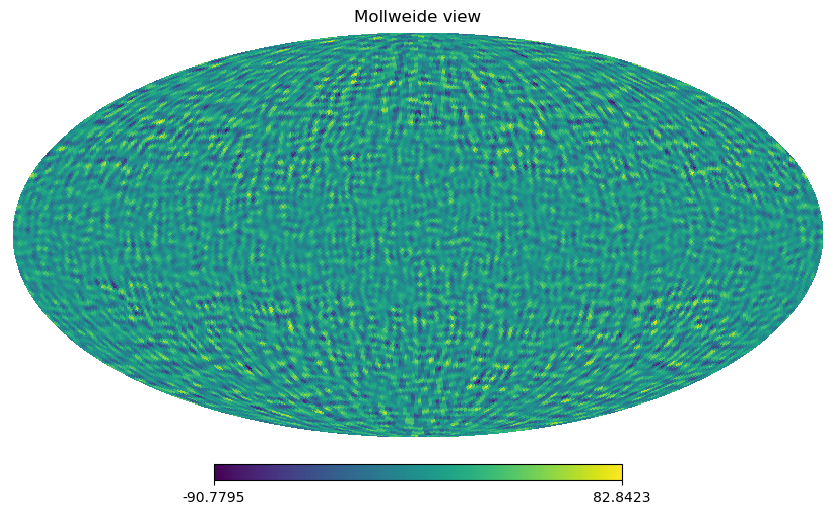

In [96]:
hp.mollview(fluct_map_2e[0])
hp.mollview(fluct_map_2e[1])
hp.mollview(fluct_map_2e_lineax[0])
hp.mollview(fluct_map_2e_lineax[1])
hp.mollview(test_initial_guess[:MICMAC_sampler_obj.n_pix])
hp.mollview(test_initial_guess[MICMAC_sampler_obj.n_pix:])

In [25]:
generated_noise_cell = c_ells.mean(axis=0)
red_generated_noise_cell = micmac.get_reduced_matrix_from_c_ell(generated_noise_cell)

In [26]:
f_sky = mask.sum()/mask.size

In [27]:
MICMAC_sampler_obj.freq_noise_c_ell.shape

(6, 6, 129)

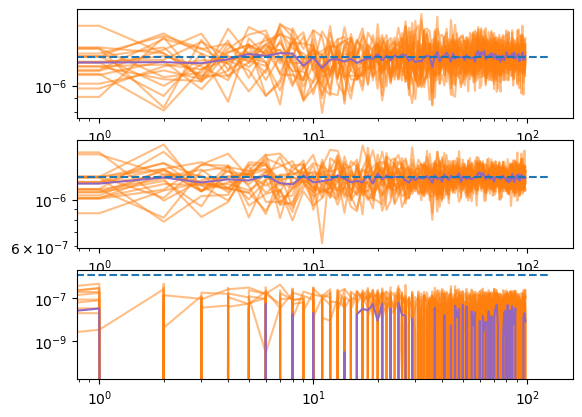

In [28]:
plt.figure()
for j in range(3):
    plt.subplot(3,1,j+1)
    for i in range(num_samples):
        plt.plot(c_ells[i,j]/f_sky, 'tab:orange', alpha=.5)

    plt.plot(c_ells.mean(axis=0)[j]/f_sky, 'tab:purple')
    plt.plot(noise_cell_2, '--')

    plt.loglog()
plt.show()

In [29]:
np.arange(10).reshape(5,2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [30]:
red_solution_c = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_generated_noise_cell, red_cov_matrix_sqrt))
red_solution_c = jnp.eye(nstokes) - jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_generated_noise_cell, red_cov_matrix_sqrt)

precond_test_c = lambda x: micmac.maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), 
                                                                 red_solution_c, 
                                                                 nside=MICMAC_sampler_obj.nside, 
                                                                 lmin=MICMAC_sampler_obj.lmin, 
                                                                 n_iter=MICMAC_sampler_obj.n_iter).ravel()


In [31]:
def CG_lineax(precond_func, right_member_to_compute, initial_guess=jnp.empty(0)):

    if jnp.size(initial_guess) == 0:
            initial_guess = jnp.zeros_like(right_member_to_compute)
    # Test Lineax
    func_norm = lambda x : jnp.linalg.norm(x,ord=2)

    CG_solver = lx.CG(rtol=MICMAC_sampler_obj.tolerance_CG, atol=MICMAC_sampler_obj.atol_CG, max_steps=MICMAC_sampler_obj.limit_iter_cg, norm=func_norm)

    # func_lineax_test = lx.FunctionLinearOperator(func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.n_pix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))
    func_lineax_test = lx.FunctionLinearOperator(func_to_apply, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.n_pix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

    if precond_func is not None:
        precond_lineax = lx.FunctionLinearOperator(precond_func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.n_pix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))
        options_dict = {"y0":initial_guess.ravel(), 'preconditioner':precond_lineax}
    else:
        options_dict = {"y0":initial_guess.ravel()}
    solution = lx.linear_solve(func_lineax_test, right_member_to_compute, solver=CG_solver, throw=False, options=options_dict)
    # solution = lx.linear_solve(func_lineax_test, s_cML.ravel(), throw=False)
    print(solution.stats)

    solution_lineax = solution.value.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix))
    return solution_lineax

In [32]:
def get_right_member_WF(self):
    N_c_repeat = jnp.broadcast_to(invBtinvNB[0,0]*jhp.nside2resol(self.nside)**2, (self.nstokes,self.n_pix)).ravel() 
    ## Repeat N_c for each Stokes parameter, for speed-up afterwards
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
    N_c_inv_repeat = jnp.broadcast_to(N_c_inv, (self.nstokes,self.n_pix)).ravel() ## Repeat N_c_inv for each Stokes parameter, for speed-up afterwards

    # invNc_s_cML_bl = self.get_band_limited_maps(s_cML*N_c_inv)
    invNc_s_cML_bl = s_cML*N_c_inv
    ## Then, computation of C^{1/2} N_c^{-1} s_c,ML
    return micmac.maps_x_red_covariance_cell_JAX(invNc_s_cML_bl, red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()

def get_right_member_Fluct(self, jax_key_PNRG):
    jax_key_PNRG, jax_key_PNRG_xi = random.split(jax_key_PNRG) # Splitting of the random key to generate a new one

    # Creation of the random maps if they are not given
        # If no random maps are provided, then it is computed within the routine
    print("Recalculating xi !")
    map_random_realization_xi = jax.random.normal(jax_key_PNRG_xi, shape=(self.nstokes,self.n_pix))/jhp.nside2resol(self.nside)

    jax_key_PNRG, *jax_key_PNRG_chi = random.split(jax_key_PNRG,self.n_frequencies+1) # Splitting of the random key to generate a new one
    # If no random maps are provided, then it is computed within the routine
    print("Recalculating chi !")
    def fmap(random_key):
        random_map = jax.random.normal(random_key, shape=(self.nstokes,self.n_pix))
        # return self.get_band_limited_maps(random_map)
        return random_map
    map_random_realization_chi = jax.vmap(fmap)(jnp.array(jax_key_PNRG_chi)) # Generating a different random Gaussian map for each frequency

    chx.assert_shape(map_random_realization_chi, (self.n_frequencies, self.nstokes, self.n_pix))

    # Computation of the right side member of the CG

    # First right member : xi
    right_member_1 = map_random_realization_xi

    # Second right member :
    ## Computation of C^{1/2} N_c^{-1/2} \chi
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0]/jhp.nside2resol(self.nside)**2)
    N_c_inv_repeat = jnp.broadcast_to(N_c_inv, (self.nstokes,self.n_pix)).ravel() 
    # Repeat N_c_inv for each Stokes parameter, for speed-up afterwards

    ## Computation of N_c^{-1/2} \chi = (E^t (B^t N^{-1} B)^{-1} E) E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \chi
    right_member_2_part = jnp.einsum('kcp,cfp,fsp->ksp', invBtinvNB, BtinvN_sqrt, map_random_realization_chi)[0]*N_c_inv # [0] for selecting CMB component of the random variable
    # First compute N_c^{-1/2} \chi 
    right_member_2 = micmac.maps_x_red_covariance_cell_JAX(right_member_2_part, red_cov_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
    # Then apply C^{1/2} to N_c^{-1/2} \chi

    # right_member = (right_member_1 + right_member_2).ravel()
    # right_member = self.get_band_limited_maps(right_member_1 + right_member_2).ravel()
    right_member = self.get_band_limited_maps(right_member_1).ravel() + right_member_2.ravel()
    return right_member

right_member_WF = get_right_member_WF(MICMAC_sampler_obj)
right_member_Fluct = get_right_member_Fluct(MICMAC_sampler_obj, random.PRNGKey(0))

Recalculating xi !
Recalculating chi !


In [33]:
jax_key_PNRG = random.PRNGKey(0)

In [34]:
MICMAC_sampler_obj.atol_CG = 10**(-6)
MICMAC_sampler_obj.atol_CG

1e-06

In [35]:
MICMAC_sampler_obj.tolerance_CG

1e-08

In [36]:
MICMAC_sampler_obj.limit_iter_cg = 2000


In [92]:
%%time
fluct_map_2e = MICMAC_sampler_obj.get_fluctuating_term_maps_v2d(
                                  red_cov_matrix_sqrt, 
                                  invBtinvNB, 
                                  BtinvN_sqrt, 
                                  jax_key_PNRG, 
                                  map_random_realization_xi=None, 
                                  map_random_realization_chi=None, 
                                  initial_guess=jnp.empty(0),
                                  precond_func=None)

Recalculating xi !
Recalculating chi !
CG Fluct finished with None iterations in  14.275821208953857 seconds !!
CPU times: user 43.3 s, sys: 5.91 s, total: 49.2 s
Wall time: 15 s


In [32]:
%%time
fluct_map_2e_lineax = CG_lineax(None, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 55.6 s, sys: 6.87 s, total: 1min 2s
Wall time: 21.2 s


In [33]:
%%time
fluct_map_2e_lineax = CG_lineax(precond_test_b, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(130, dtype=int64)}
CPU times: user 53.6 s, sys: 6.45 s, total: 1min
Wall time: 19.1 s


In [68]:
%%time
fluct_map_2e_lineax = CG_lineax(precond_test_c, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 1min 22s, sys: 10.6 s, total: 1min 32s
Wall time: 30.4 s


In [146]:
%%time
fluct_map_2e_precond = MICMAC_sampler_obj.get_fluctuating_term_maps_v2d(
                                  red_cov_matrix_sqrt, 
                                  invBtinvNB, 
                                  BtinvN_sqrt, 
                                  jax_key_PNRG, 
                                  map_random_realization_xi=None, 
                                  map_random_realization_chi=None, 
                                  initial_guess=jnp.empty(0),
                                  precond_func=precond_test_b)

Recalculating xi !
Recalculating chi !
CG Fluct finished with None iterations in  26.859750986099243 seconds !!
CPU times: user 1min 19s, sys: 10.1 s, total: 1min 29s
Wall time: 27.7 s


In [49]:
%%time
fluct_map_2e_precond = MICMAC_sampler_obj.get_fluctuating_term_maps_v2d(
                                  red_cov_matrix_sqrt, 
                                  invBtinvNB, 
                                  BtinvN_sqrt, 
                                  jax_key_PNRG, 
                                  map_random_realization_xi=None, 
                                  map_random_realization_chi=None, 
                                  initial_guess=jnp.empty(0),
                                  precond_func=precond_test)

Recalculating xi !
Recalculating chi !


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: KeyboardInterrupt: <EMPTY MESSAGE>

At:
  healpy/src/_sphtools.pyx(359): healpy._sphtools.map2alm
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/healpy/sphtfunc.py(274): map2alm
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/astropy/utils/decorators.py(604): wrapper
  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/micmac/jax_tools.py(315): wrapper_map2alm
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/callback.py(258): _flat_callback
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/callback.py(52): pure_callback_impl
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/callback.py(188): _callback
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/interpreters/mlir.py(2069): _wrapped_callback
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/interpreters/pxla.py(1149): __call__
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/profiler.py(314): wrapper
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/dispatch.py(132): apply_primitive
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(821): process_primitive
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(389): bind_with_trace
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(2604): bind
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(454): eval_jaxpr
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(235): jaxpr_as_fun
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/lax/control_flow/solves.py(308): _custom_linear_solve_impl
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(821): process_primitive
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(389): bind_with_trace
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/core.py(2604): bind
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/lax/control_flow/solves.py(286): custom_linear_solve
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/traceback_util.py(177): reraise_with_filtered_traceback
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/scipy/sparse/linalg.py(230): _isolve
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/jax/_src/scipy/sparse/linalg.py(290): cg
  /Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/micmac/jax_Sampling_toolbox.py(414): get_fluctuating_term_maps_v2d
  <timed exec>(1): <module>
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/magics/execution.py(1325): time
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/interactiveshell.py(2475): run_cell_magic
  /var/folders/f8/p6tqlgxj2qn5x_tyjrvc1vnh0000gn/T/ipykernel_29405/542538476.py(1): <module>
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3505): run_code
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3445): run_ast_nodes
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3266): run_cell_async
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3061): _run_cell
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/interactiveshell.py(3006): run_cell
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/ipkernel.py(446): do_execute
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/kernelbase.py(778): execute_request
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/ipkernel.py(359): execute_request
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/kernelbase.py(437): dispatch_shell
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/kernelbase.py(534): process_one
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/kernelbase.py(545): dispatch_queue
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/asyncio/events.py(80): _run
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/asyncio/base_events.py(1905): _run_once
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/asyncio/base_events.py(601): run_forever
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/tornado/platform/asyncio.py(205): start
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel/kernelapp.py(739): start
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/traitlets/config/application.py(1075): launch_instance
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/ipykernel_launcher.py(18): <module>
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/runpy.py(87): _run_code
  /Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/runpy.py(197): _run_module_as_main


In [38]:
%%time
fluct_map_2e_lineax = CG_lineax(None, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 2000, 'num_steps': Array(220, dtype=int64)}
CPU times: user 1min 1s, sys: 7.64 s, total: 1min 8s
Wall time: 20.2 s


In [86]:
test_initial_guess = precond_test(right_member_Fluct)

In [87]:
%%time
fluct_map_2e_lineax = CG_lineax(precond_test, right_member_Fluct, initial_guess=test_initial_guess)

{'max_steps': 2000, 'num_steps': Array(218, dtype=int64)}
CPU times: user 1min 27s, sys: 10.9 s, total: 1min 37s
Wall time: 29.9 s


In [39]:
%%time
fluct_map_2e_lineax = CG_lineax(precond_test, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 2000, 'num_steps': Array(219, dtype=int64)}
CPU times: user 1min 28s, sys: 11.1 s, total: 1min 39s
Wall time: 30 s


In [35]:
%%time
fluct_map_2e_lineax = CG_lineax(precond_test_2b, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 1min 21s, sys: 9.79 s, total: 1min 31s
Wall time: 27.3 s


In [36]:
%%time
fluct_map_2e_precond = MICMAC_sampler_obj.get_fluctuating_term_maps_v2d(MICMAC_sampler_obj,
                                  red_cov_matrix_sqrt, 
                                  invBtinvNB, 
                                  BtinvN_sqrt, 
                                  jax_key_PNRG, 
                                  map_random_realization_xi=None, 
                                  map_random_realization_chi=None, 
                                  initial_guess=jnp.empty(0),
                                  precond_func=precond_test_2b)

Recalculating xi !
Recalculating chi !
CG Fluct finished with None iterations in  25.134395122528076 seconds !!
CPU times: user 1min 18s, sys: 9.83 s, total: 1min 28s
Wall time: 26 s


In [37]:
%%time
fluct_map_2e_lineax = CG_lineax(precond_test_3, right_member_Fluct, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 1min 21s, sys: 9.68 s, total: 1min 31s
Wall time: 27.5 s


In [38]:
%%time
fluct_map_2e_precond = MICMAC_sampler_obj.get_fluctuating_term_maps_v2d(MICMAC_sampler_obj,
                                  red_cov_matrix_sqrt, 
                                  invBtinvNB, 
                                  BtinvN_sqrt, 
                                  jax_key_PNRG, 
                                  map_random_realization_xi=None, 
                                  map_random_realization_chi=None, 
                                  initial_guess=jnp.empty(0),
                                  precond_func=precond_test_3)

Recalculating xi !
Recalculating chi !
CG Fluct finished with None iterations in  25.944393157958984 seconds !!
CPU times: user 1min 18s, sys: 9.9 s, total: 1min 28s
Wall time: 26.9 s


In [39]:
%%time
fluct_map_2e_precond_b = MICMAC_sampler_obj.get_fluctuating_term_maps_v2d(MICMAC_sampler_obj,
                                  red_cov_matrix_sqrt, 
                                  invBtinvNB, 
                                  BtinvN_sqrt, 
                                  jax_key_PNRG, 
                                  map_random_realization_xi=None, 
                                  map_random_realization_chi=None, 
                                  initial_guess=jnp.empty(0),
                                  precond_func=precond_test_4)

Recalculating xi !
Recalculating chi !
CG Fluct finished with None iterations in  33.74360013008118 seconds !!
CPU times: user 1min 45s, sys: 12.9 s, total: 1min 58s
Wall time: 34.6 s


In [48]:
%%time
WF_map_2d = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2d(s_cML, 
                                                                        red_cov_matrix_sqrt, 
                                                                        invBtinvNB, 
                                                                        initial_guess=jnp.empty(0),
                                                                        precond_func=None)



CG WF finished with None iterations in  17.224623680114746 seconds !!
CPU times: user 52.6 s, sys: 6.98 s, total: 59.6 s
Wall time: 17.8 s


In [41]:
%%time
WF_map_lineax = CG_lineax(None, right_member_WF, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(200, dtype=int64)}
CPU times: user 57.5 s, sys: 6.98 s, total: 1min 4s
Wall time: 19.1 s


In [42]:
%%time
wiener_filter_term_z, number_iterations = jsp.sparse.linalg.cg(func_to_apply, 
                                                                right_member_WF.ravel(), 
                                                                tol=MICMAC_sampler_obj.tolerance_CG,
                                                                maxiter=MICMAC_sampler_obj.limit_iter_cg, 
                                                                M=precond_test_b)

CPU times: user 1min 17s, sys: 9.53 s, total: 1min 26s
Wall time: 27.2 s


In [69]:
%%time
wiener_filter_term_z, number_iterations = jsp.sparse.linalg.cg(func_to_apply, 
                                                                right_member_WF.ravel(), 
                                                                tol=MICMAC_sampler_obj.tolerance_CG,
                                                                maxiter=MICMAC_sampler_obj.limit_iter_cg, 
                                                                M=precond_test_c)

CPU times: user 1min 17s, sys: 10.2 s, total: 1min 27s
Wall time: 25.7 s


In [43]:
%%time
WF_map_lineax_precond = CG_lineax(precond_test_b, right_member_WF, initial_guess=jnp.empty(0))

{'max_steps': 200, 'num_steps': Array(135, dtype=int64)}
CPU times: user 55.5 s, sys: 6.51 s, total: 1min 2s
Wall time: 18.3 s


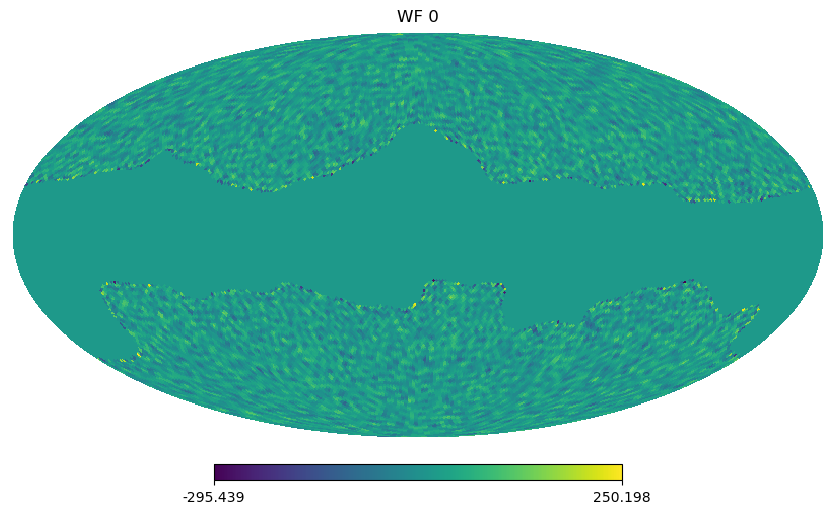

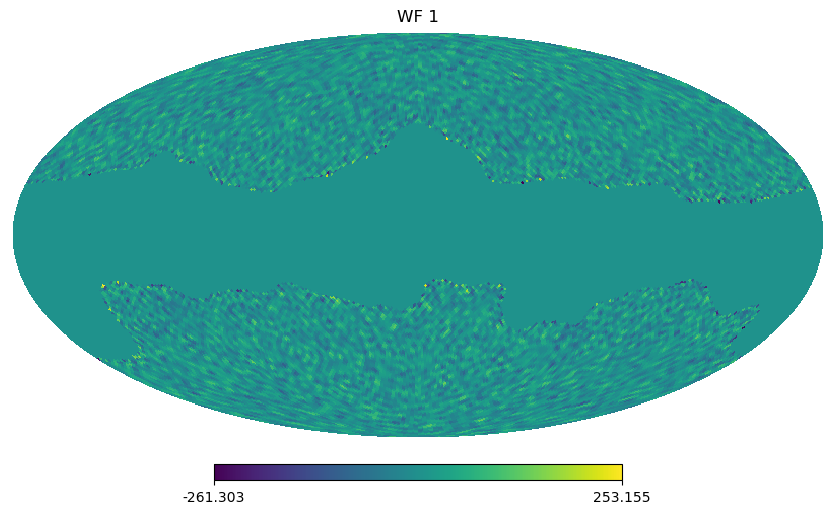

In [44]:
for i in range(2):
    hp.mollview(wiener_filter_term_z[i*MICMAC_sampler_obj.n_pix:(i+1)*MICMAC_sampler_obj.n_pix], title='WF '+str(i))


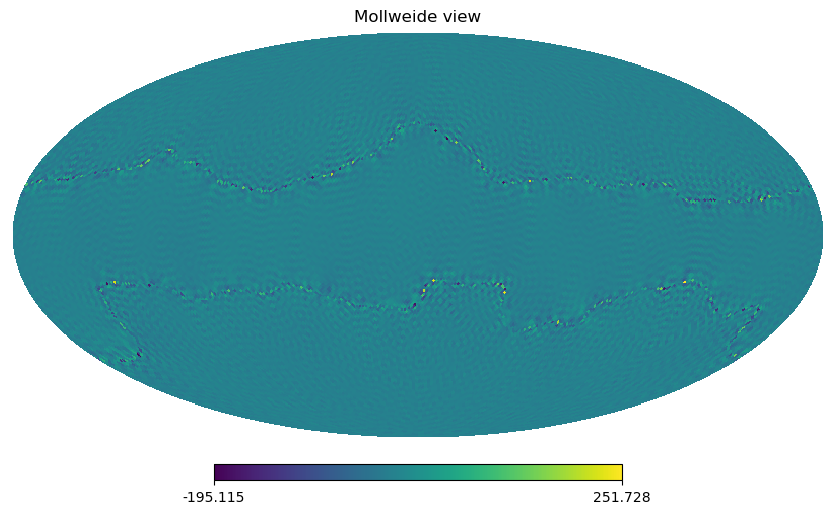

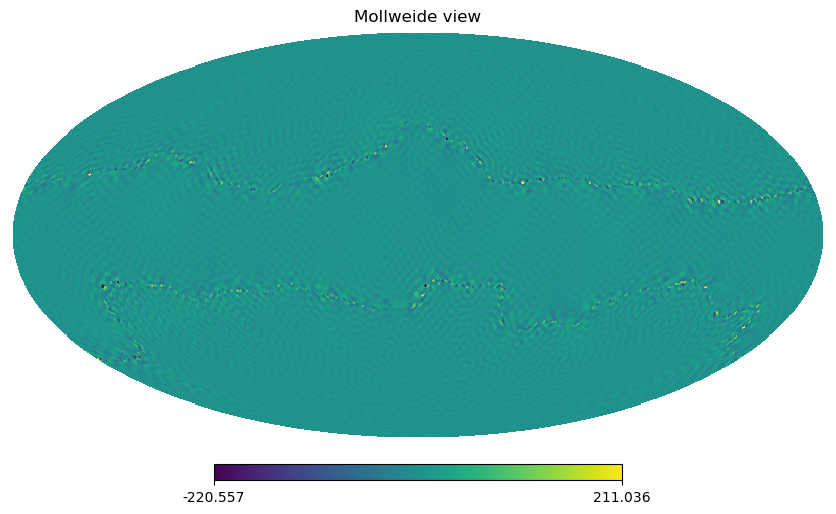

In [45]:
for i in range(2):
    hp.mollview(WF_map_lineax[i]-WF_map_lineax_precond[i])


In [46]:
%%time
WF_map_2d_precond = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2d(s_cML, 
                                                                        red_cov_matrix_sqrt, 
                                                                        invBtinvNB, 
                                                                        initial_guess=jnp.empty(0),
                                                                        precond_func=precond_test_b)

CG WF finished with None iterations in  24.512633085250854 seconds !!
CPU times: user 1min 17s, sys: 9.39 s, total: 1min 27s
Wall time: 25 s


In [47]:
%%time
WF_map_2d_precond = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2d(s_cML, 
                                                                        red_cov_matrix_sqrt, 
                                                                        invBtinvNB, 
                                                                        initial_guess=jnp.empty(0),
                                                                        precond_func=precond_test_3)

CG WF finished with None iterations in  23.249599933624268 seconds !!
CPU times: user 1min 13s, sys: 8.94 s, total: 1min 22s
Wall time: 23.8 s


In [48]:
%%time
WF_map_2d_precond_b = MICMAC_sampler_obj.solve_generalized_wiener_filter_term_v2d(s_cML, 
                                                                        red_cov_matrix_sqrt, 
                                                                        invBtinvNB, 
                                                                        initial_guess=jnp.empty(0),
                                                                        precond_func=precond_test_4)

CG WF finished with None iterations in  31.82125210762024 seconds !!
CPU times: user 1min 38s, sys: 12 s, total: 1min 50s
Wall time: 32.3 s


In [79]:
%%time
WF_map_lineax_precond = CG_lineax(None, right_member_WF, initial_guess=jnp.empty(0))

{'max_steps': 2000, 'num_steps': Array(209, dtype=int64)}
CPU times: user 58.2 s, sys: 7.13 s, total: 1min 5s
Wall time: 19.1 s


In [82]:
red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell*f_sky, red_cov_matrix_sqrt))
# red_solution = jnp.linalg.pinv(jnp.eye(nstokes) + jnp.einsum('lij,ljk,lkm->lim', red_cov_matrix_sqrt, red_inv_noise_c_ell, red_cov_matrix_sqrt))/f_sky

precond_test = lambda x: micmac.maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.n_pix)), red_solution, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter).ravel()


In [83]:
%%time
WF_map_lineax_precond = CG_lineax(precond_test, right_member_WF, initial_guess=jnp.empty(0))

{'max_steps': 2000, 'num_steps': Array(203, dtype=int64)}
CPU times: user 1min 21s, sys: 10 s, total: 1min 31s
Wall time: 25.6 s


In [78]:
%%time
WF_map_lineax_precond = CG_lineax(precond_test, right_member_WF, initial_guess=jnp.empty(0))

{'max_steps': 2000, 'num_steps': Array(203, dtype=int64)}
CPU times: user 1min 22s, sys: 10.3 s, total: 1min 32s
Wall time: 27.6 s


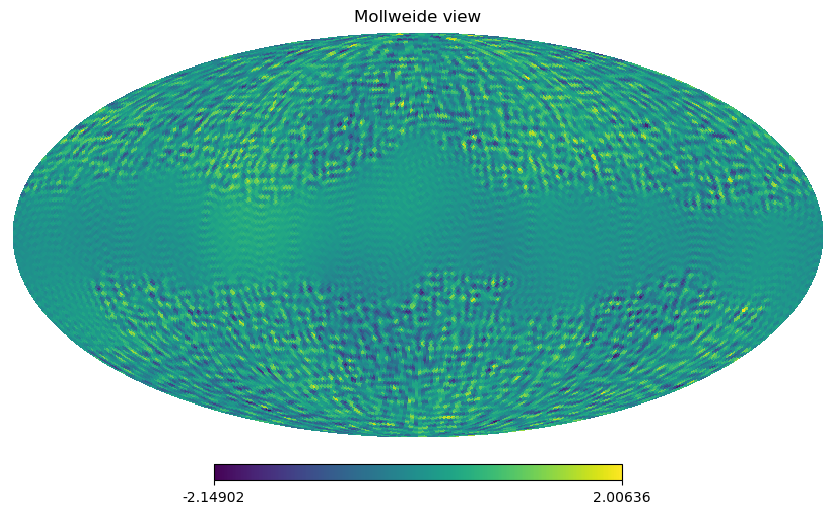

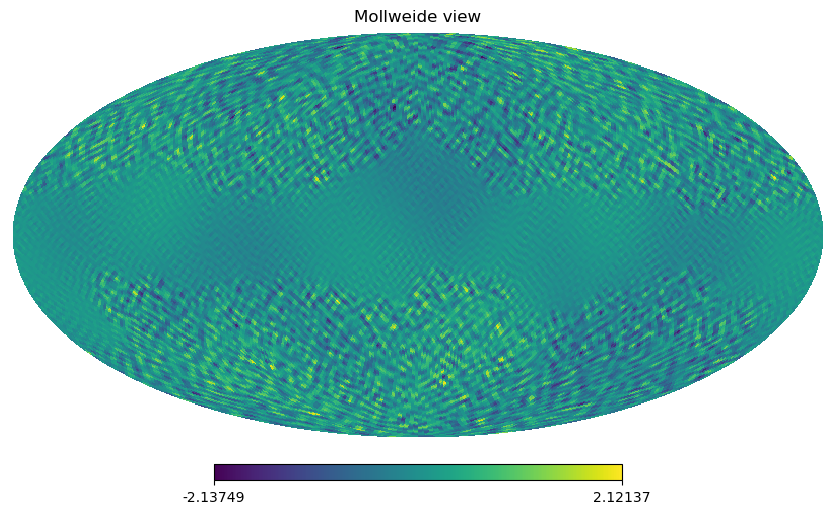

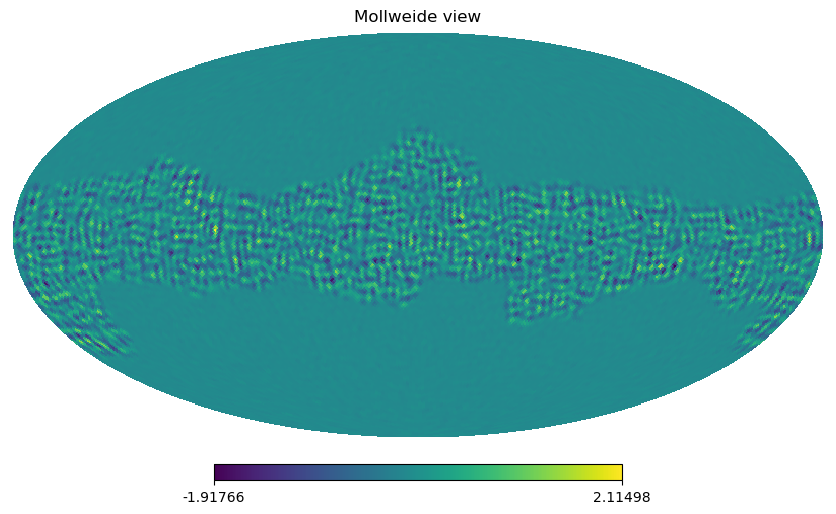

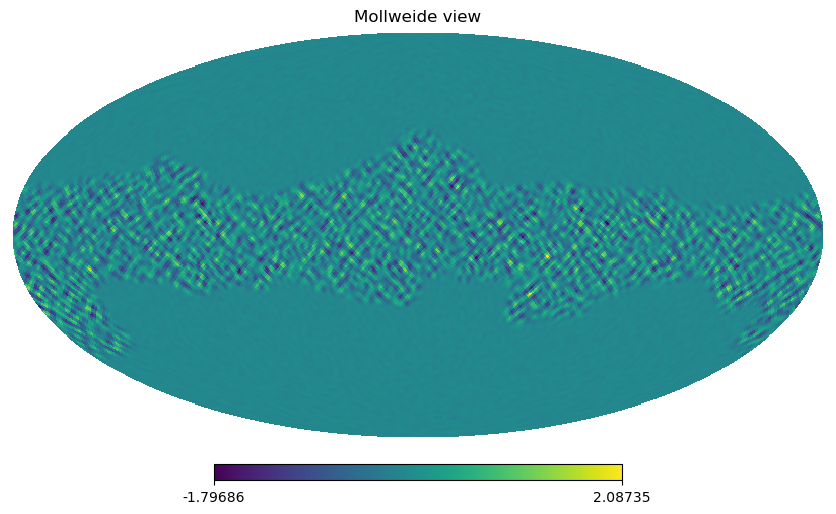

In [50]:
for i in range(2):
    hp.mollview(WF_map_2d[i])
for i in range(2):
    hp.mollview(fluct_map_2e[i])

## Results

In [51]:
n_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = n_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(n_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

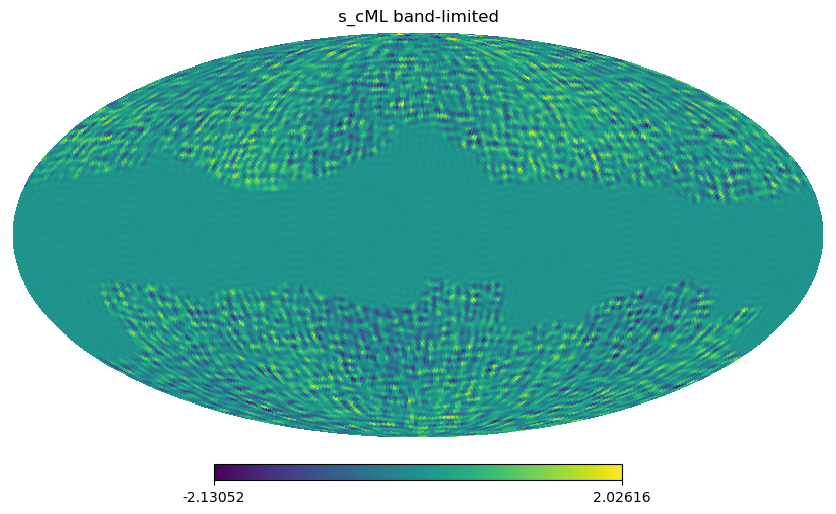

In [52]:
s_cMML_bl = MICMAC_sampler_obj.get_band_limited_maps(s_cML)

hp.mollview(s_cMML_bl[0], title='s_cML band-limited')

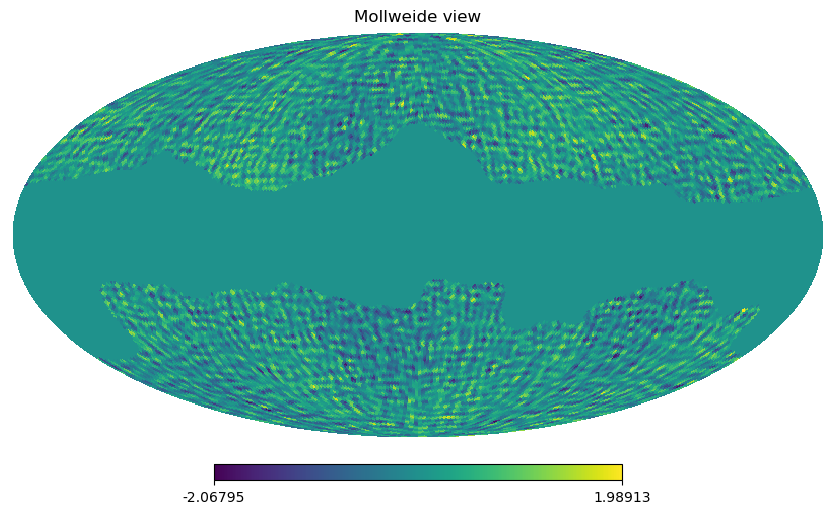

In [53]:
hp.mollview(s_cML[0])

In [54]:
# WF_map_2d = WF_map_2d*MICMAC_sampler_obj.mask

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


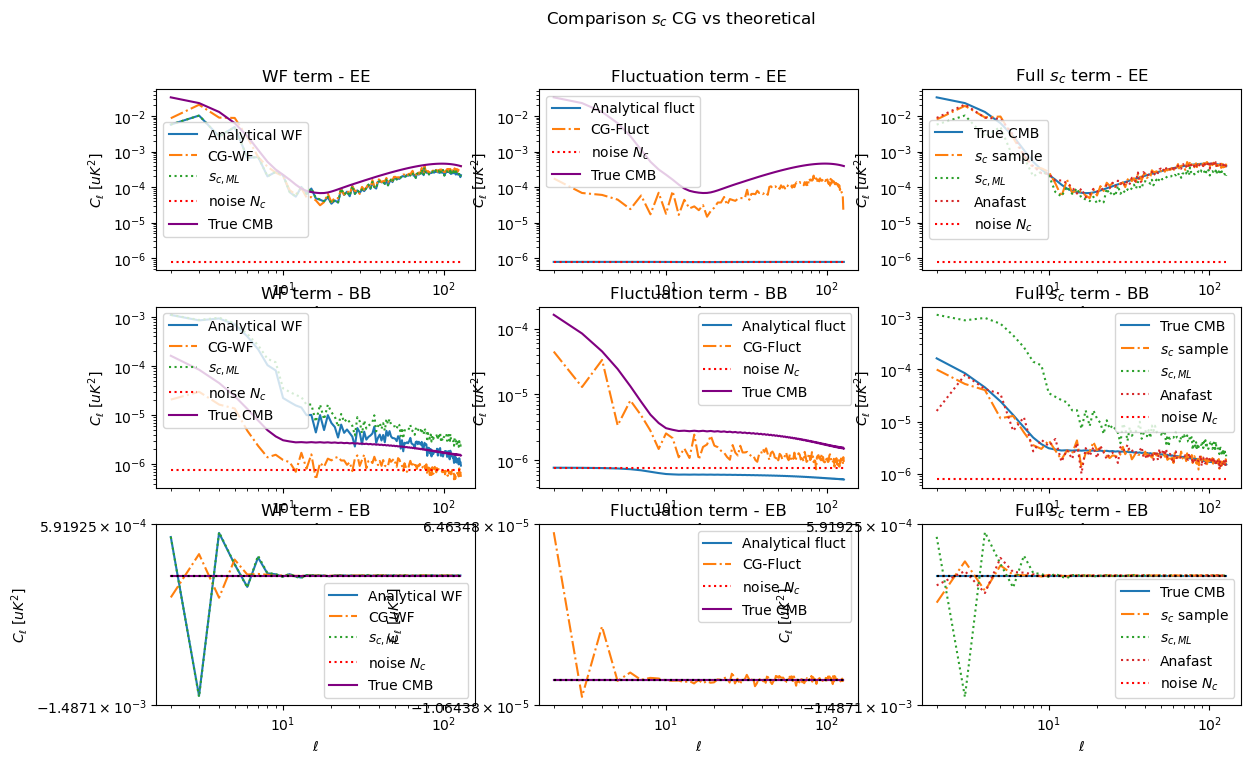

In [55]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0]), input_cmb_maps[0]])
c_ell_realisation_CMB = hp.anafast(input_cmb_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_matrix_sample.shape[0]) + MICMAC_sampler_obj.lmin

# _cl_noise_harm = 1/MICMAC_sampler_obj.freq_noise_c_ell[0,0,lmin:]
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))

N_c_inv = jnp.copy(invBtinvNB[0,0])
N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
       
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML*N_c_inv,
                                                                    analytical_WF_harm, lmin=lmin, n_iter=n_iter)


full_map_s_c = WF_map_2d + fluct_map_2e
full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(WF_map_2d[0]), WF_map_2d])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluct_map_2e[0]), fluct_map_2e])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

s_c_recovered = WF_map_2d + fluct_map_2e
s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(n_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], color='purple', label='True CMB')
    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], color='purple', label='True CMB')

    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_realisation_CMB[j,:], ':', label='Anafast')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")

    plt.xlabel(r"$\ell$")
    plt.legend()
plt.show()

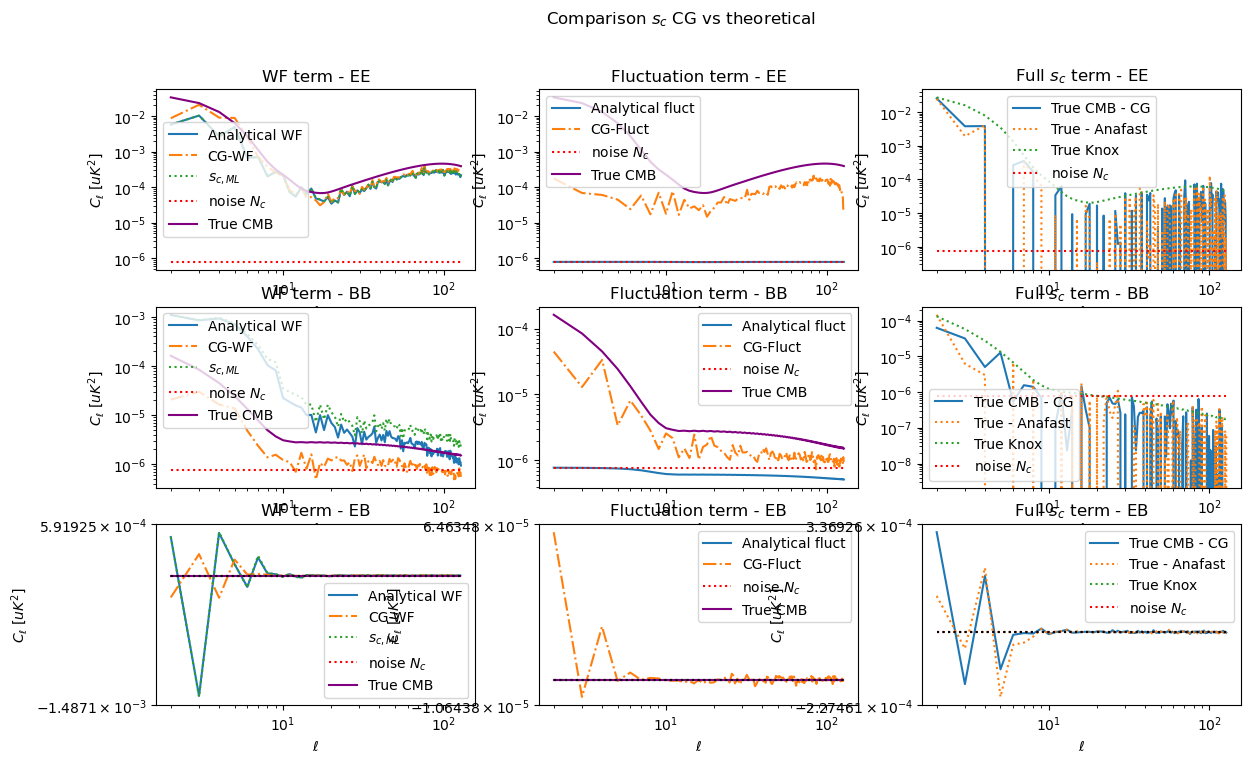

In [56]:
list_correl = ['EE', 'BB', 'EB']

c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)#[indices_polar, :]

input_cmb_maps_extended = np.vstack([np.zeros_like(input_cmb_maps[0,0]), input_cmb_maps[0]])
c_ell_realisation_CMB = hp.anafast(input_cmb_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

ell_arange = np.arange(red_cov_matrix_sample.shape[0]) + MICMAC_sampler_obj.lmin

# _cl_noise_harm = 1/MICMAC_sampler_obj.freq_noise_c_ell[0,0,lmin:]
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled.mean(axis=2), lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))

N_c_inv = jnp.copy(invBtinvNB[0,0])
N_c_inv = N_c_inv.at[...,MICMAC_sampler_obj.mask!=0].set(1/invBtinvNB[0,0,MICMAC_sampler_obj.mask!=0]/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
       
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML*N_c_inv,
                                                                    analytical_WF_harm, lmin=lmin, n_iter=n_iter)


full_map_s_c = WF_map_2d + fluct_map_2e
full_map_s_cML_extended = np.vstack([np.zeros_like(s_cML[0,...]), s_cML])
c_ell_s_cML = hp.anafast(full_map_s_cML_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(WF_map_2d[0]), WF_map_2d])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluct_map_2e[0]), fluct_map_2e])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

s_c_recovered = WF_map_2d + fluct_map_2e
s_c_recovered_ext = np.vstack([np.zeros_like(s_c_recovered[0]),s_c_recovered])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(n_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], color='purple', label='True CMB')
    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:], color='purple', label='True CMB')

    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    ell_array = np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:]-c_ells_s_c[j,:], label='True CMB - CG')
    # plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, , '-.', label='$s_c$ sample')
    # plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_s_cML[j,:], ':', label='$s_{c,ML}$')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:]-c_ell_realisation_CMB[j,:], ':', label='True - Anafast')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, c_ell_true_CMB[j,:]*np.sqrt(2/((2*ell_array+1)*.6)), ':', label='True Knox')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")

    plt.xlabel(r"$\ell$")
    plt.legend()
plt.show()

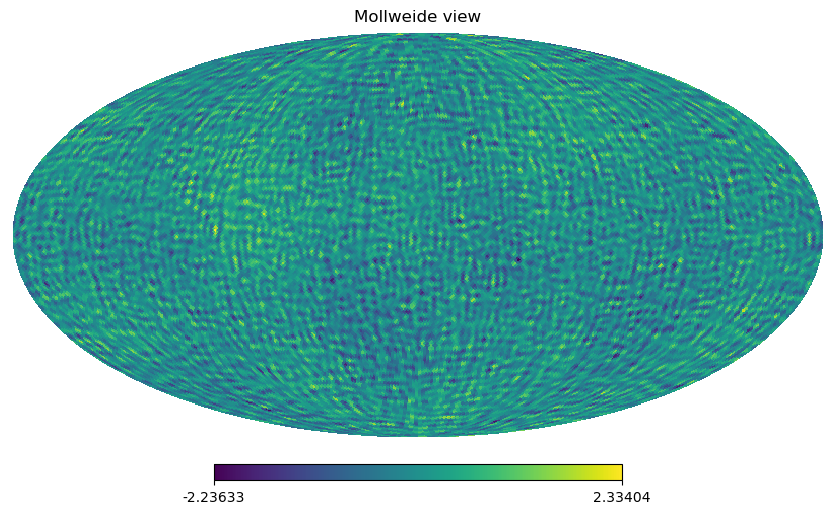

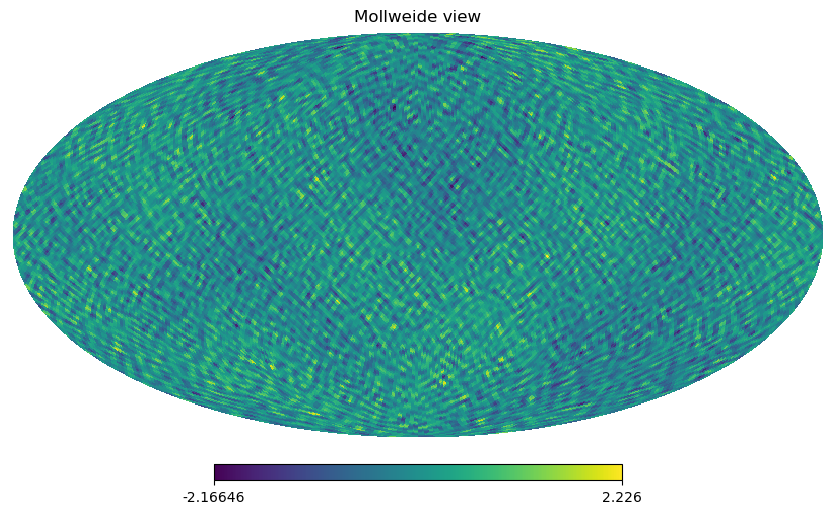

In [57]:
for i in range(2):
    hp.mollview(s_c_recovered[i])